# Mechanistic Interpretability Analysis: URL-Title Classifier

This notebook performs MI analysis on the `firefoxrecap/URL-TITLE-classifier` model. 

**Analyses:**
1. Setup and Model Loading
2. Helper Functions (Plotting, Analysis Logic)
3. Data Definition (Examples for analysis)
4. Baseline Attention Visualization (CLS, Separator)
5. Head Importance Analysis (Attribution & URL-Title Pattern)
6. Combined Importance & Top Head Identification
7. Deep Dive into Important Heads
8. Token Importance (Gradient Attribution)
9. Conclusion


## 1. Setup and Model Loading

In [1]:
# %pip install torch transformers numpy matplotlib scikit-learn # Uncomment if needed

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the tokenizer and model
MODEL_NAME = "firefoxrecap/URL-TITLE-classifier"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    output_attentions=True,
    output_hidden_states=False # Can be False unless needed for other analyses
).to(device)
model.eval() # Set to evaluation mode

# Get model configuration
config = model.config
num_layers = config.num_hidden_layers
num_heads = config.num_attention_heads
print(f"Model loaded: {MODEL_NAME}")
print(f"Number of layers: {num_layers}")
print(f"Number of heads: {num_heads}")
print(f"Labels: {config.id2label}") # Display labels from config

Using device: cpu
Model loaded: firefoxrecap/URL-TITLE-classifier
Number of layers: 22
Number of heads: 12
Labels: {0: 'News', 1: 'Entertainment', 2: 'Shop', 3: 'Chat', 4: 'Education', 5: 'Government', 6: 'Health', 7: 'Technology', 8: 'Work', 9: 'Travel', 10: 'Uncategorized'}


## 2. Helper Functions

In [4]:

def get_model_outputs(text):
    """Tokenizes text and gets model outputs including attentions."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    # attentions shape: (num_layers, batch_size, num_heads, seq_len, seq_len)
    # Squeeze batch_size dimension
    attentions = [layer_attn[0].detach().cpu() for layer_attn in outputs.attentions] # List of (num_heads, seq_len, seq_len)
    logits = outputs.logits.detach().cpu()
    
    # For multi-label: Apply sigmoid and get all predictions above threshold
    probs = torch.sigmoid(logits)[0]  # Apply sigmoid to get probabilities
    threshold = 0.5  # Common threshold value, can be adjusted
    pred_indices = torch.where(probs >= threshold)[0].tolist()  # Indices where prob >= threshold
    pred_labels = [model.config.id2label[idx] for idx in pred_indices]
    pred_probs = {label: probs[idx].item() for idx, label in zip(pred_indices, pred_labels)}

    return {
        "inputs": inputs.to('cpu'),
        "tokens": tokens,
        "attentions": attentions,
        "logits": logits,
        "pred_indices": pred_indices,
        "pred_labels": pred_labels,
        "pred_probs": pred_probs
    }

def find_url_title_separator(tokens, url, title):
    """More robustly find the separator index between URL and Title tokens."""
    # Simple approach: find the first token likely belonging to the title,
    # assuming title starts after url and potential separator token(s) like ':'
    # This might need refinement based on tokenizer behavior.
    url_tokens = tokenizer.tokenize(url)
    # Find the approximate end of URL tokens in the combined list
    # This is tricky due to potential subword splitting differences
    # A simpler heuristic: find the ':' token if present, otherwise estimate
    try:
        # Add special tokens ([CLS], [SEP]) to the count for indexing
        sep_indices = [i for i, token in enumerate(tokens) if token == ':']
        if sep_indices:
            return sep_indices[0] # Assume first colon is the main separator
    except ValueError:
        pass # Colon not found as a distinct token

    # Fallback: Estimate based on URL token length (less reliable)
    # This requires careful checking of how tokens align.
    # For now, we'll rely on finding ':' or return None if impossible.
    print(f"Warning: Could not reliably find separator for tokens: {tokens}")
    return None # Indicate failure

def plot_attention_map(attention_matrix, tokens, layer_idx, head_idx, title_suffix="", figsize=(8, 8), dpi=100):
    """Plots a single attention heatmap."""
    num_tokens = len(tokens)
    if attention_matrix.shape[0] != num_tokens or attention_matrix.shape[1] != num_tokens:
         print(f"Warning: Mismatch between attention shape {attention_matrix.shape} and token count {num_tokens}. Skipping plot.")
         return

    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(attention_matrix, cmap="viridis", norm=mcolors.Normalize(vmin=0.0, vmax=1.0)) # Normalize colorbar
    plt.title(f"Layer {layer_idx + 1} - Head {head_idx + 1} {title_suffix}", fontsize=14)
    plt.xlabel("Key Tokens", fontsize=12)
    plt.ylabel("Query Tokens", fontsize=12)
    plt.xticks(ticks=np.arange(num_tokens), labels=tokens, rotation=90, fontsize=10)
    plt.yticks(ticks=np.arange(num_tokens), labels=tokens, fontsize=10)
    plt.colorbar(fraction=0.046, pad=0.04, label="Attention Probability")
    plt.clim(0, 1) # Explicitly set color limits
    plt.tight_layout()
    plt.show()

def compute_head_attribution(model, tokenizer, example_texts):
    """
    Alternative approach to measure head importance using attention activation values
    instead of masking, which may not be supported properly by this model.
    """
    model.to(device)
    head_importance = torch.zeros(num_layers, num_heads).to(device)
    
    print(f"Computing head attribution over {len(example_texts)} examples...")
    for i, text in enumerate(example_texts):
        print(f"  Processing example {i+1}/{len(example_texts)}...", end='\r')
        
        # Get outputs including attentions
        outputs = get_model_outputs(text)
        attentions = outputs['attentions']  # List of (num_heads, seq_len, seq_len) tensors
        pred_indices = outputs['pred_indices']  # FIXED: use 'pred_indices' instead of 'pred_idx'
        
        # Compute CLS token attention influence
        for layer_idx, layer_attention in enumerate(attentions):
            for head_idx in range(num_heads):
                # Focus on CLS token's attention pattern (how it attends to other tokens)
                cls_attention = layer_attention[head_idx, 0, :]  # CLS is at position 0
                # Measure entropy of attention distribution - lower entropy = more focused attention
                # Higher value means this head has sharper focus
                entropy = -torch.sum(cls_attention * torch.log2(cls_attention + 1e-10))
                # Invert entropy so higher values = more important (focused heads)
                head_importance[layer_idx, head_idx] += (10.0 - entropy)
    
    print("\nHead attribution computation complete.")
    # Average and normalize
    head_importance = head_importance / len(example_texts)
    head_importance = (head_importance - head_importance.min()) / (head_importance.max() - head_importance.min() + 1e-10)
    return head_importance.cpu()

def compute_url_title_attention(example_texts):
    """
    Measures the average attention between URL tokens and Title tokens
    across all layers and heads. Requires finding the separator.
    Returns a tensor of shape (num_layers, num_heads).
    """
    url_title_attention_scores = torch.zeros(num_layers, num_heads)
    valid_examples = 0

    print(f"Computing URL-Title attention patterns over {len(example_texts)} examples...")
    for i, text in enumerate(example_texts):
        print(f"  Processing example {i+1}/{len(example_texts)}...", end='\r')
        # Basic split assumption
        parts = text.split(':', 1)
        if len(parts) != 2: continue # Skip if no clear separator
        url, title = parts[0], parts[1]

        outputs = get_model_outputs(text)
        tokens = outputs['tokens']
        attentions = outputs['attentions'] # List of (num_heads, seq_len, seq_len) tensors

        # Find separator index relative to tokens list (includes [CLS], [SEP])
        sep_idx = find_url_title_separator(tokens, url, title)

        # +1 for CLS token, check if separator found and makes sense
        if sep_idx is None or sep_idx <= 1 or sep_idx >= len(tokens) - 2:
            # print(f"Skipping example due to separator issue: {text[:50]}...")
            continue # Skip if separator is not reliably found or at edges

        valid_examples += 1
        num_tokens = len(tokens)
        # Define URL tokens (after CLS, up to separator) and Title tokens (after separator, before SEP)
        url_token_indices = slice(1, sep_idx)
        title_token_indices = slice(sep_idx + 1, num_tokens - 1) # Exclude [SEP]

        if url_token_indices.stop <= url_token_indices.start or \
           title_token_indices.stop <= title_token_indices.start:
            # print(f"Skipping example due to empty URL/Title span: {text[:50]}...")
            continue # Skip if spans are invalid


        for layer_idx, layer_attention in enumerate(attentions):
            # layer_attention shape: (num_heads, seq_len, seq_len)
            for head_idx in range(num_heads):
                attn_matrix = layer_attention[head_idx] # (seq_len, seq_len)

                # Extract attention submatrices
                url_to_title_attn = attn_matrix[url_token_indices, title_token_indices]
                title_to_url_attn = attn_matrix[title_token_indices, url_token_indices]

                # Calculate mean attention, handle potential empty slices if indices were bad
                mean_url_to_title = url_to_title_attn.mean().item() if url_to_title_attn.numel() > 0 else 0
                mean_title_to_url = title_to_url_attn.mean().item() if title_to_url_attn.numel() > 0 else 0

                # Store the average cross-attention
                url_title_attention_scores[layer_idx, head_idx] += (mean_url_to_title + mean_title_to_url) / 2

    if valid_examples == 0:
        print("\nWarning: No valid examples found for URL-Title attention analysis.")
        return url_title_attention_scores # Return zeros

    print(f"\nURL-Title attention computation complete ({valid_examples} valid examples).")
    # Average over valid examples
    url_title_attention_scores /= valid_examples
    return url_title_attention_scores

def compute_token_importance_gradients(text):
    """Computes token importance using gradients of the predicted logit w.r.t embeddings."""
    model.to(device).train() # Put model in train mode for gradients, but use detach later
    model.zero_grad()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Get embeddings and ensure gradients are required
    embeddings = model.get_input_embeddings()(inputs['input_ids'])
    embeddings.retain_grad() # Ensure gradient is stored

    # Forward pass using embeddings
    outputs = model(inputs_embeds=embeddings, attention_mask=inputs['attention_mask'])
    logits = outputs.logits

    # Target for gradient calculation: the predicted class logit
    pred_idx = torch.argmax(logits, dim=-1).item()
    target_logit = logits[0, pred_idx]

    # Backpropagate
    target_logit.backward()

    # Get gradients and compute L2 norm
    grads = embeddings.grad[0].detach().cpu().numpy() # Shape: (seq_len, hidden_dim)
    token_importance = np.linalg.norm(grads, axis=1)

    model.eval() # Return model to evaluation mode
    return tokens, token_importance, model.config.id2label[pred_idx]


def plot_head_matrix(scores_matrix, title="Head Importance Scores", cmap="viridis", N=5):
    """Visualizes head importance scores and identifies top N heads."""
    if torch.is_tensor(scores_matrix):
        scores_matrix = scores_matrix.detach().cpu().numpy()

    # Normalize scores for better visualization if needed (e.g., if ranges vary wildly)
    # scaler = MinMaxScaler()
    # scores_matrix_norm = scaler.fit_transform(scores_matrix)
    scores_matrix_norm = scores_matrix # Or use original scores if range is reasonable

    plt.figure(figsize=(12, 9))
    im = plt.imshow(scores_matrix_norm, cmap=cmap, aspect='auto')
    plt.colorbar(im, label="Importance Score")

    plt.xticks(np.arange(num_heads), [f"H{i+1}" for i in range(num_heads)])
    plt.yticks(np.arange(num_layers), [f"L{i+1}" for i in range(num_layers)])
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.title(title, fontsize=14)

    # Add text labels for top N values to reduce clutter
    flat_indices = np.argsort(scores_matrix.flatten())[-N:][::-1] # Top N
    top_coords = [(idx // num_heads, idx % num_heads) for idx in flat_indices]

    print(f"Top {N} Heads ({title}):")
    for i, (r, c) in enumerate(top_coords):
        score = scores_matrix[r, c]
        print(f"  {i+1}. Layer {r+1}, Head {c+1}: {score:.4f}")
        # Use white text for dark cells, black for light cells
        text_color = "white" if scores_matrix_norm[r, c] < 0.6 * scores_matrix_norm.max() else "black"
        plt.text(c, r, f"{score:.2f}", ha="center", va="center", color=text_color, fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.grid(False)
    plt.show()

    return top_coords # Return (layer, head) indices of top heads

## 3. Data Definition
This should probably use some better data points 

In [5]:
example_texts = [
    # News
    "https://www.reuters.com/markets/deals/blackstone-evaluates-taking-stake-us-tiktok-spinoff-2025-03-28/:Exclusive: Blackstone mulls small stake in US TikTok spinoff, sources say",
    "https://www.reuters.com/business/finance:Global stocks slip as investors brace for Fed minutes",
    # Entertainment
    "https://www.youtube.com:Youtube",
    "https://www.netflix.com/browse:Netflix - Watch TV Shows Online, Watch Movies Online",
    # Shop
    "https://www.amazon.com/deals?ref_=nav_cs_gb:Today's Deals on Amazon.com",
    "https://www.etsy.com:Etsy - Shop for handmade, vintage, custom, and unique gifts",
    # Education
    "https://www.coursera.org/:Coursera | Online Courses & Credentials From Top Educators. Join for Free",
    "https://www.khanacademy.org/:Khan Academy | Free Online Courses, Lessons & Practice",
    # Technology
    "https://github.com/:GitHub: Where the world builds software",
    "https://stackoverflow.com/:Stack Overflow - Where Developers Learn, Share, & Build Careers",
    # Travel
    "https://www.expedia.com/:Expedia Travel: Vacation Homes, Hotels, Car Rentals, Flights & More",
    "https://www.airbnb.com/:Vacation Rentals, Homes, Experiences & Places - Airbnb",
    # Health
    "https://www.webmd.com/:WebMD - Better information. Better health.",
    "https://www.nih.gov/:National Institutes of Health (NIH)",
    # Work / Productivity (assuming 'Work' label)
    "https://slack.com/intl/en-gb/:Slack is your digital HQ",
    "https://docs.google.com/:Google Docs: Online Document Editor",
    # Chat (May overlap with Work)
    "https://discord.com/:Your Place to Talk and Hang Out",
    "https://web.whatsapp.com/:WhatsApp Web",
    # Government
    "https://www.irs.gov/:Internal Revenue Service | An official website of the United States government",
    "https://www.gov.uk/:Welcome to GOV.UK",
    # Uncategorized / Misc
    "https://sdfakjsdfha.com/:sdkfjas",
    "https://19dj36.com/:u2buh329n6i8vm5v99cy2kouhowq4589uyrev92n8c7y"
]

## 4. Baseline Attention Visualization
Let's look at attention patterns for one or two examples, focusing on [CLS] and separator tokens. for this model [:] is the separator and [CLS] is important because this is a classification task.

Compiling the model with `torch.compile` and using a `torch.cpu` device is not supported. Falling back to non-compiled mode.



Analyzing example: https://www.reuters.com/markets/deals/blackstone-evaluates-taking-stake-us-tiktok-spinoff-2025-03-28/:Exclusive: Blackstone mulls small stake in US TikTok spinoff, sources say
Predictions:
  - News (0.95)
  - Entertainment (0.69)
  - Technology (0.91)
Tokens: ['[CLS]', 'https', '://', 'www', '.', 're', 'uters', '.', 'com', '/', 'markets', '/', 'de', 'als', '/', 'black', 'stone', '-', 'eval', 'uates', '-', 'taking', '-', 'st', 'ake', '-', 'us', '-', 'tik', 'tok', '-', 'sp', 'ino', 'ff', '-', '20', '25', '-', '03', '-', '28', '/', ':', 'Ex', 'clusive', ':', 'ĠBlack', 'stone', 'Ġm', 'ulls', 'Ġsmall', 'Ġstake', 'Ġin', 'ĠUS', 'ĠT', 'ik', 'Tok', 'Ġsp', 'ino', 'ff', ',', 'Ġsources', 'Ġsay', '[SEP]']


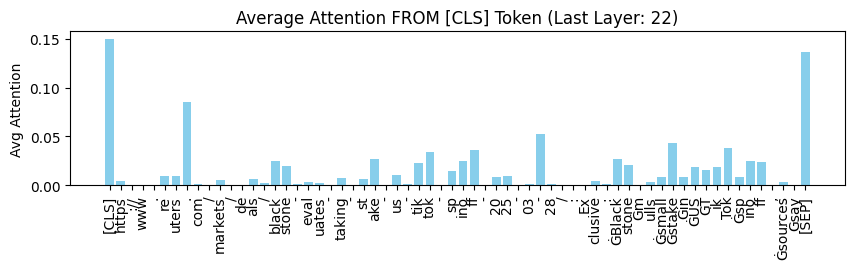

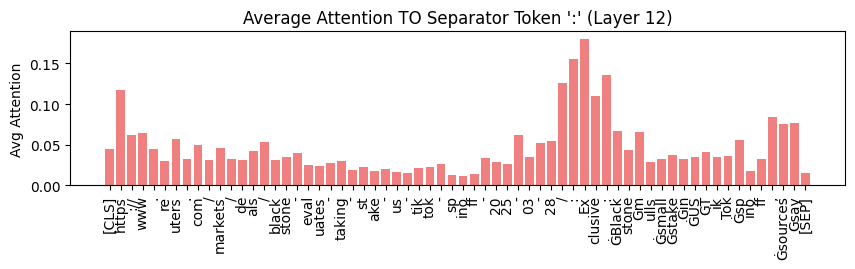


Analyzing example: https://www.reuters.com/business/finance:Global stocks slip as investors brace for Fed minutes
Predictions:
  - News (0.99)
  - Technology (0.74)
Tokens: ['[CLS]', 'https', '://', 'www', '.', 're', 'uters', '.', 'com', '/', 'business', '/', 'fin', 'ance', ':', 'Global', 'Ġstocks', 'Ġslip', 'Ġas', 'Ġinvestors', 'Ġbrace', 'Ġfor', 'ĠFed', 'Ġminutes', '[SEP]']


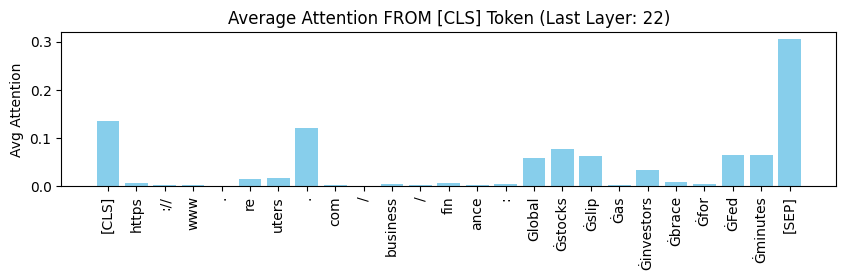

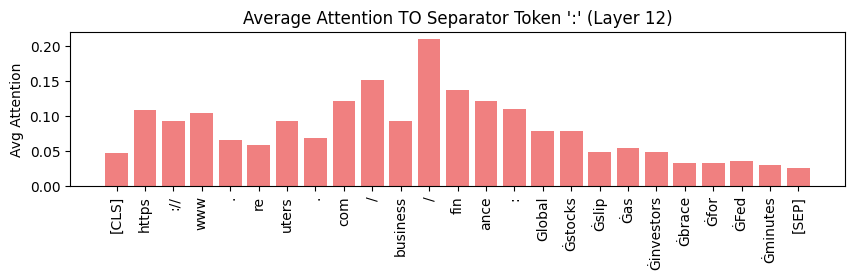

In [6]:
for i in range(min(2, len(example_texts))): # Analyze first two examples
    text = example_texts[i]
    print(f"\nAnalyzing example: {text}")
    outputs = get_model_outputs(text)
    tokens = outputs['tokens']
    attentions = outputs['attentions'] # List of layer attentions
    pred_labels = outputs['pred_labels']
    pred_probs = outputs['pred_probs']
    
    # Display all predicted labels and their probabilities
    print(f"Predictions:")
    for label in pred_labels:
        print(f"  - {label} ({pred_probs[label]:.2f})")
    print(f"Tokens: {tokens}")

    url, title = text.split(':', 1) if ':' in text else (text, "")
    sep_idx = find_url_title_separator(tokens, url, title)

    # Visualize attention FROM [CLS] token in the last layer
    last_layer_idx = num_layers - 1
    cls_attention_last_layer = attentions[last_layer_idx][:, 0, :] # All heads, query is CLS (idx 0)
    avg_cls_attention = cls_attention_last_layer.mean(dim=0).numpy() # Average over heads

    plt.figure(figsize=(10, 2))
    plt.bar(range(len(tokens)), avg_cls_attention, color='skyblue')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.ylabel("Avg Attention")
    plt.title(f"Average Attention FROM [CLS] Token (Last Layer: {last_layer_idx+1})")
    plt.show()

    # Visualize attention TO separator token (if found) in a middle layer
    if sep_idx is not None:
        mid_layer_idx = num_layers // 2
        sep_attention_mid_layer = attentions[mid_layer_idx][:, :, sep_idx] # All heads, key is Separator
        avg_sep_attention = sep_attention_mid_layer.mean(dim=0).numpy() # Average over heads

        plt.figure(figsize=(10, 2))
        plt.bar(range(len(tokens)), avg_sep_attention, color='lightcoral')
        plt.xticks(range(len(tokens)), tokens, rotation=90)
        plt.ylabel("Avg Attention")
        plt.title(f"Average Attention TO Separator Token ':' (Layer {mid_layer_idx+1})")
        plt.show()

## 5. Head Importance Analysis

Computing head attribution over 22 examples...
  Processing example 22/22...
Head attribution computation complete.
Top 10 Heads (Head Importance (Attribution via KL Div)):
  1. Layer 10, Head 11: 1.0000
  2. Layer 19, Head 3: 0.9851
  3. Layer 13, Head 2: 0.9356
  4. Layer 19, Head 9: 0.9219
  5. Layer 14, Head 12: 0.9216
  6. Layer 13, Head 7: 0.9127
  7. Layer 4, Head 3: 0.8690
  8. Layer 13, Head 12: 0.8670
  9. Layer 21, Head 4: 0.8536
  10. Layer 1, Head 4: 0.8424


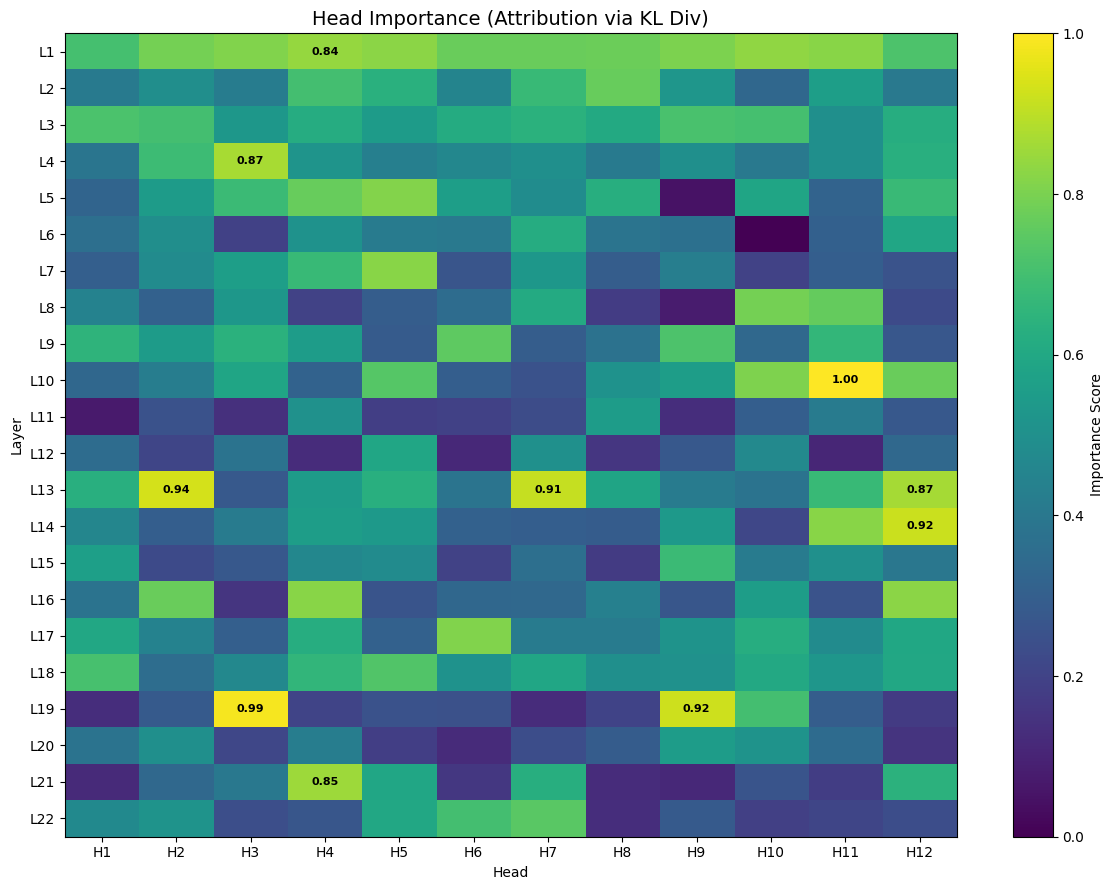

Computing URL-Title attention patterns over 22 examples...
  Processing example 22/22...
URL-Title attention computation complete (22 valid examples).


In [7]:
# Attribution Score (KL Divergence)
attribution_scores = compute_head_attribution(model, tokenizer, example_texts)
top_attribution_heads = plot_head_matrix(attribution_scores, title="Head Importance (Attribution via KL Div)", N=10)

# URL-Title Attention Pattern Score
pattern_scores = compute_url_title_attention(example_texts)


## 6. Combined Importance & Top Head Identification

Top 10 Heads (Combined Head Importance (Attribution * Pattern)):
  1. Layer 21, Head 4: 1.0000
  2. Layer 1, Head 4: 0.9280
  3. Layer 19, Head 3: 0.5457
  4. Layer 19, Head 9: 0.5353
  5. Layer 17, Head 4: 0.5251
  6. Layer 21, Head 5: 0.5204
  7. Layer 19, Head 10: 0.5145
  8. Layer 18, Head 7: 0.5095
  9. Layer 17, Head 6: 0.4963
  10. Layer 18, Head 5: 0.4878


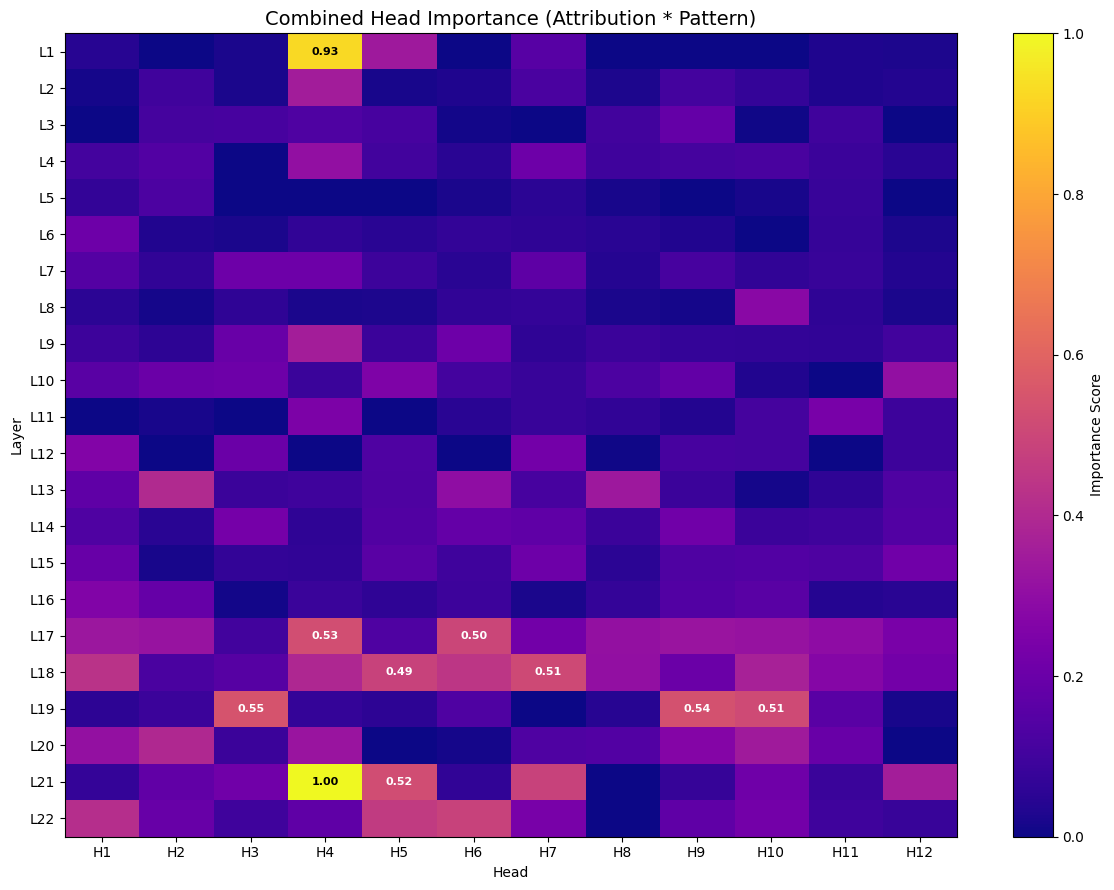

NameError: name 'top_pattern_heads' is not defined

In [9]:

# Combine scores. Normalizing before combining can be useful.
# Simple approach: Element-wise multiplication (favors heads strong in both)
# Alternative: Rank averaging, or selecting heads in top-N of both lists.
scaler = MinMaxScaler()
attr_scores_norm = scaler.fit_transform(attribution_scores.numpy())
pattern_scores_norm = scaler.fit_transform(pattern_scores.numpy())

# Multiply normalized scores
# Add small epsilon to pattern scores if they can be zero to avoid killing importance
combined_importance = torch.tensor(attr_scores_norm * (pattern_scores_norm + 1e-6))

top_combined_heads_coords = plot_head_matrix(combined_importance, title="Combined Head Importance (Attribution * Pattern)", cmap="plasma", N=10)


# Identify heads appearing in top N of both individual lists
top_attr_set = set(top_attribution_heads[:15]) # Look in top 15 for potential overlap
top_pattern_set = set(top_pattern_heads[:15])
overlapping_top_heads = list(top_attr_set.intersection(top_pattern_set))

print(f"\nHeads in Top 15 of BOTH Attribution and Pattern scores:")
if overlapping_top_heads:
    for layer, head in overlapping_top_heads:
        print(f"  Layer {layer+1}, Head {head+1}")
else:
    print("  None found in Top 15 overlap.")

# Select heads for deep dive: Top combined + Top overlapping
heads_for_deep_dive = list(set(top_combined_heads_coords[:5] + overlapping_top_heads))
# Ensure coords are unique and sort them
heads_for_deep_dive = sorted(list(set(heads_for_deep_dive)))

print(f"\nSelected Heads for Deep Dive: {[(l+1, h+1) for l,h in heads_for_deep_dive]}")


## 7. Deep Dive into Important Heads

In [ ]:

if not heads_for_deep_dive:
    print("No specific heads identified for deep dive based on criteria.")
else:
    # Analyze the first few examples again, focusing on these heads
    num_examples_to_show = 3
    for i in range(min(num_examples_to_show, len(example_texts))):
        text = example_texts[i]
        print(f"\n-- Analyzing Example: {text[:80]}... --")
        outputs = get_model_outputs(text)
        tokens = outputs['tokens']
        attentions = outputs['attentions']
        pred_labels = outputs['pred_labels']
        pred_probs = outputs['pred_probs']
        
        print("Predictions:")
        for label in pred_labels:
            print(f"  - {label} ({pred_probs[label]:.2f})")
        
        for layer_idx, head_idx in heads_for_deep_dive:
            if layer_idx >= len(attentions) or head_idx >= attentions[layer_idx].shape[0]:
                print(f"Skipping L{layer_idx+1} H{head_idx+1} - Index out of bounds for this example?")
                continue
            
            attn_matrix = attentions[layer_idx][head_idx].numpy()
            plot_attention_map(attn_matrix, tokens, layer_idx, head_idx, 
                              title_suffix=f"(Example {i+1})", figsize=(7,7), dpi=80)
            # Add description based on visual inspection or further quantitative analysis
            # E.g., "This head seems to focus attention from title keywords back to the main domain in the URL."


## 8. Token Importance (Gradient Attribution)

In [ ]:
# Update the token importance function for multi-label classification
def compute_token_importance_gradients(text):
    """Computes token importance using gradients for multi-label classification."""
    model.to(device).train()  # Put model in train mode for gradients
    model.zero_grad()
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    # Get embeddings and ensure gradients are required
    embeddings = model.get_input_embeddings()(inputs['input_ids'])
    embeddings.retain_grad()  # Ensure gradient is stored
    
    # Forward pass using embeddings
    outputs = model(inputs_embeds=embeddings, attention_mask=inputs['attention_mask'])
    logits = outputs.logits
    
    # For multi-label: Get all predictions above threshold
    probs = torch.sigmoid(logits[0])
    threshold = 0.5
    pred_indices = torch.where(probs >= threshold)[0]
    
    if len(pred_indices) == 0:
        # If no labels above threshold, use highest probability label
        pred_indices = [torch.argmax(probs).item()]
        
    # Average gradients across all predicted labels
    token_importances = {}
    for pred_idx in pred_indices:
        model.zero_grad()
        target_logit = logits[0, pred_idx]
        target_logit.backward(retain_graph=True)
        
        # Get gradients and compute L2 norm
        grads = embeddings.grad[0].detach().cpu().numpy()  # Shape: (seq_len, hidden_dim)
        token_importance = np.linalg.norm(grads, axis=1)
        
        label = model.config.id2label[pred_idx.item() if torch.is_tensor(pred_idx) else pred_idx]
        token_importances[label] = token_importance
    
    model.eval()  # Return model to evaluation mode
    return tokens, token_importances, [model.config.id2label[idx.item() if torch.is_tensor(idx) else idx] for idx in pred_indices]

# Analyze token importance for a few examples
num_examples_to_show = 3
for i in range(min(num_examples_to_show, len(example_texts))):
    text = example_texts[i]
    print(f"\n-- Analyzing Example: {text} --")
    
    tokens, token_importances, pred_labels = compute_token_importance_gradients(text)
    print(f"Predictions: {', '.join(pred_labels)}")
    print(f"Tokens: {tokens}")
    
    # Create a figure with subplots for each predicted label
    fig, axes = plt.subplots(len(token_importances), 1, figsize=(10, 4*len(token_importances)))
    if len(token_importances) == 1:
        axes = [axes]  # Handle case with single subplot
        
    for ax_idx, (label, token_importance) in enumerate(token_importances.items()):
        ax = axes[ax_idx]
        ax.bar(range(len(tokens)), token_importance, color='skyblue')
        ax.set_xticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=90)
        ax.set_title(f"Token Importance for {label}")
        ax.set_xlabel("Tokens")
        ax.set_ylabel("L2 Norm of Gradient")
    
    plt.tight_layout()
    plt.show()
    
    # Print token importances for each label
    for label, token_importance in token_importances.items():
        print(f"\nToken importance for {label} (L2 norm of gradients):")
        imp_list = []
        for token, imp in zip(tokens, token_importance):
            if imp > 0.01:  # Only show significant contributions
                imp_list.append(f"{token}: {imp:.4f}")
        print(", ".join(imp_list[:15]) + ("..." if len(imp_list) > 15 else ""))